In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import imp
import torchaudio
import torchvision as tv
import matplotlib.pyplot as plt
from IPython.display import Audio
import os, random
import pandas as pd
import mir_utils as miru
from torch.utils.data import Dataset, DataLoader
import librosa
import librosa.display
import pytorch_models
imp.reload(miru)
imp.reload(pytorch_models)
SR=44100
#functions
spec=torchaudio.functional.spectrogram

audio_frames=miru.audioFrames(loadCache=True)

def getMeanLength(x):
    gl=x.apply(lambda z: len(z["audio"]),axis=1)
    print(gl.mean()/SR,gl.mean(),x["label"].iloc[0])
    
# audio_frames.groupby(by=["label_num"]).apply(lambda x:getMeanLength(x))
# getMeanLength(audio_frames)


def getRandAud():
    classes=os.listdir("./dk_data/")
    rand_class=random.choice(classes)
#     rand_class="synth_noise"
    rand_sample=random.choice(os.listdir("./dk_data/%s/"%(rand_class,)))
    return "./dk_data/"+rand_class+"/"+rand_sample
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# list(zip(uniques,range(0,len(uniques))))

audio_frames=audio_frames.loc[~audio_frames["label"].isin(["shake","guitar","piano"])]        
#split the dataframe into 2 seperate ones:
drum_frames=audio_frames.loc[~audio_frames["label"].isin(["synth_noise","guitar","piano"])]
#split the dataframe into 2 seperate ones:
not_drum_frames=audio_frames.loc[audio_frames["label"].isin(["synth_noise","guitar","piano"])]


In [4]:
#make two label series, one for drum vs not drum classification, one for drum type classification
#add the series to the dataframe 
# print(drum_labels,not_drum_labels)

#drum only classification
# audio_frames["label_num"].isin(not_drum_labels)
dLabels, dUniques=pd.factorize(drum_frames["label"].tolist())
ndLabels, ndUniques=pd.factorize(not_drum_frames["label"].tolist())

drum_frames["label_num"]=dLabels
not_drum_frames["label_num"]=ndLabels+len(dUniques)

allU=np.concatenate([dUniques,ndUniques])
lmap=list(zip(allU,range(len(allU))))

#get weights for each group
# x=drum_frames.groupby(["label"]).agg("count")["path"]
y=audio_frames.groupby(["label"]).agg("count")["path"]
print(y)
weights=torch.tensor([1000/w for w in y.tolist()])


label
clap             118
hihat_closed     187
hihat_open       280
kick             648
rim              105
snare            731
synth_noise     6000
tom_high         179
tom_low          188
tom_mid          139
Name: path, dtype: int64


/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/asalimi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
class audioDataset(torch.utils.data.Dataset):
    def __init__(self,audio_frame,root_dir, task="keep_all",transform=None):
        self.root_dir=root_dir
        self.task=task
        self.audio_frame=audio_frame
        self.transform = transform
        self.minLength=SR
#         self.minLength=SR//4
        self.frame_pruning()
    def __len__(self):
        return len(self.audio_frame)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        rows=self.audio_frame.iloc[idx]

        signals,labels=rows["audio"].tolist()[0:SR],rows["label_num"].tolist()
        signals,labels=torch.tensor(signals),torch.tensor(labels)
        
        nz=np.max((self.minLength-signals.shape[0],0))
        signals=torch.cat([signals[0:self.minLength],torch.zeros(nz)],dim=0)

        sound={"signal":signals,"label":labels,"path":rows["path"],"drum_type":rows["label"]}
        
        if self.transform:
            sound = self.transform(sound)

        return sound
    
    def frame_pruning(self):
        #drum vs not drum classification:
        drum_label_numbers=range(len(dUniques))
        if self.task=="dvn":
            self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=0
            self.audio_frame.loc[~self.audio_frame["label_num"].isin(drum_label_numbers),"label_num"]=1
        #drum type classification
        if self.task=="dvd":
            self.audio_frame=self.audio_frame.loc[self.audio_frame["label_num"].isin(drum_label_numbers)]
        if self.task=="keep_all":
            pass
            
ds=audioDataset(pd.concat([drum_frames,not_drum_frames]),"./",task="dvn",)
idx=np.random.randint(0,len(ds),5)
all_frames=pd.concat([drum_frames,not_drum_frames])
train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)


In [6]:
train["audio"].iloc[2].shape

(13110,)

torch.Size([30, 20])
('tom_high', 0) tensor(0) 44100


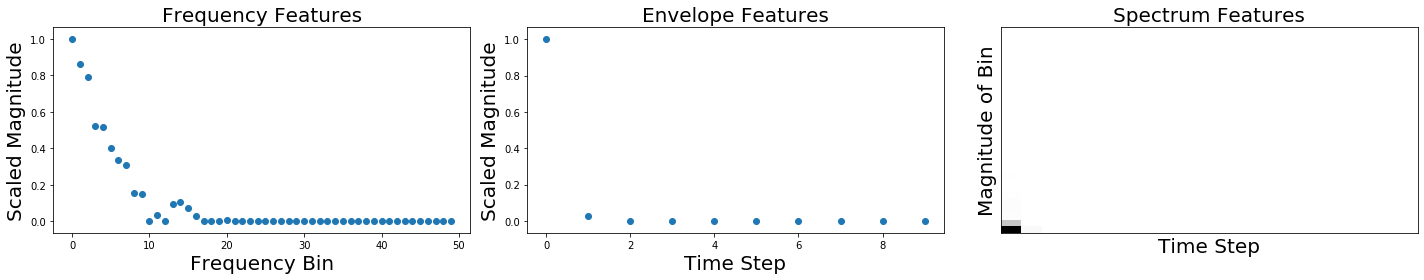

In [7]:
FREQ_BINS=30
TIME_STEPS=20
#defining transformations
class freqTrans(object):
    def __init__(self,num_mels=50,SR=SR):
        self.num_mels=num_mels
        self.ampT=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=30)
        self.melF=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
        
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR//4
        wf=wf[:,0:24000]
        num_bins=wf[0].shape[0]
        win_length=num_bins
        hop_step=sample_length//(self.num_mels)
        window=torch.tensor([1]*win_length)
        s=spec(wf, 100, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melF(s)
        s=self.ampT(s)
        freq=s.sum(axis=0).sum(axis=1)
        freq=freq-freq.min()
        freq=freq/freq.max()
        freq[torch.isnan(freq)]=0
        return {"feats":freq.detach(),"label":label}

class envTrans(object):
    def __init__(self,num_mels=10,SR=SR):
        self.env_size=9
        self.num_mels=num_mels
        self.amp=torchaudio.transforms.AmplitudeToDB(stype='power', top_db=60)
        self.melEnv=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR, f_min=30.0, f_max=None, n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    def __call__(self, sample):
        wf,label=sample["signal"],sample["label"]
        
        wf=wf.reshape(-1,len(wf))
        sample_length=SR
        num_bins=wf[0].shape[0]
        win_length=SR//20
        hop_step=SR//self.env_size
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window,win_length, hop_step, win_length,2,normalized=False)
        s=self.melEnv(s)
        s=self.amp(s)
#         s=self.norm(s)
        #normalizing
        env=s.sum(axis=0).sum(axis=0)
        env=env-env.min()
        env=env/env.max()
        env[torch.isnan(env)]=0

        num_padding=torch.max(torch.tensor([self.env_size+1-env.shape[0],0]))
        env_vec=torch.cat([env.detach(),torch.zeros(num_padding)],dim=0)
        return {"feats":env_vec.detach(),"label":label}

class feats_and_env(object):
    def __init__(self,feat_mels=50,env_mels=1):
        self.ft=freqTrans(num_mels=feat_mels)
        self.et=envTrans(num_mels=env_mels)

    def __call__(self, sample):
            combined_feats=torch.cat((self.ft(sample)["feats"],self.et(sample)["feats"]))
            return {"feats":combined_feats,"label":sample["label"]}
        

class specTrans(object):
    def __init__(self,num_mels=50,SR=SR,time_steps=20):
        self.num_mels=num_mels
        self.ampP=torchaudio.transforms.AmplitudeToDB(stype='power',top_db=60)
        self.melP=torchaudio.transforms.MelScale(n_mels=self.num_mels, sample_rate=SR,n_stft=None)
#         self.norm= transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        self.hop_step=time_steps-1
    def __call__(self, sample):
        
        wf,label,p,drum_type=sample["signal"],sample["label"],sample["path"],sample["drum_type"]
        wf=wf.reshape(-1,len(wf))
        sample_length=SR

        num_bins=wf[0].shape[0]
        win_length=SR//17
        hop_step=SR//self.hop_step
        window=torch.tensor([1]*win_length)
        s=spec(wf, 0, window, num_bins, hop_step, win_length,2,normalized=False)
        s=self.melP(s)
#         s=self.ampP(s)
        s = s - s.min()
        s = s/s.abs().max()

        freq=s
#         freq=self.norm(s)
        freq[torch.isnan(freq)]=0
        freq=freq[0]
        return {"feats":freq.detach(),"label":label,"path":p,"drum_type":drum_type}

#Apply each of the above transforms on sample.
fig = plt.figure(figsize=(20,4))
# while True:
sample = ds[np.random.randint(len(ds))]
#     print(sample["label"].item())
#     if sample["label"].item()==1:
#         break
# freq_train = audioDataset(train,".",task="dvd")
# f_train_loader= DataLoader(freq_train, batch_size=16, num_workers=1)
# sample=iter(f_train_loader).next()
# s={"signal":sample["signal"][0],"label":sample["label"][0],"path":sample["path"],"drum_type":sample["drum_type"]}
# sample=s
tfList=[freqTrans(50),envTrans(num_mels=10,SR=SR),specTrans(FREQ_BINS,time_steps=TIME_STEPS)]

for i, tsfrm in enumerate(tfList):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ft=transformed_sample["feats"]
    if i==0:
        plt.title("Frequency Features",fontsize=20)
        plt.xlabel("Frequency Bin",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)
                   
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==1:
        plt.title("Envelope Features",fontsize=20)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Scaled Magnitude",fontsize=20)            
        plt.scatter(y=ft,x=range(0,len(ft)))
    if i==2:
        print(ft.shape,)
        sf=ft.detach().numpy()
        ft=ft.detach().numpy()
        plt.title("Spectrum Features",fontsize=20)
        librosa.display.specshow(sf,cmap='gray_r',)
        plt.xlabel("Time Step",fontsize=20)
        plt.ylabel("Magnitude of Bin",fontsize=20)

#         plt.savefig("./plots/ff3.pdf",bbox_inches = "tight")
# plt.show()
print(lmap[transformed_sample["label"].item()],transformed_sample["label"],len(sample["signal"]))


Audio(sample["signal"],rate=SR,autoplay=True)


# SPEC ENCODER

In [12]:
class AE_Linear(nn.Module):
    def __init__(self,input_shape,compression_dim):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=256
        )
        self.encoder_output_layer = nn.Linear(
            in_features=256, out_features=compression_dim
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=compression_dim, out_features=256
        )
        self.decoder_output_layer = nn.Linear(
            in_features=256, out_features=input_shape
        )
    def forward(self, features):
        print(features.shape)
        print(asd)
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        self.encoding=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed


In [13]:

FREQ_BINS=30
TIME_STEPS=20
COMPRESSION_DIM=64
spec_dimension=FREQ_BINS*TIME_STEPS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pt=tv.transforms.Compose([specTrans(FREQ_BINS,time_steps=TIME_STEPS)])

train=all_frames.sample(frac=0.80,random_state=420) #random state is a seed value
test=all_frames.drop(train.index)
spec_data_train = audioDataset(train,".","dvn", transform=pt)
spec_data_test = audioDataset(test,".",task="dvn", transform=pt)
spec_train_loader= DataLoader(spec_data_train, batch_size=64,shuffle=True, num_workers=32)
spec_test_loader= DataLoader(spec_data_test, batch_size=8,shuffle=True, num_workers=6)


train_synthless=train[train["label_num"]==0]
spec_data_train_nosynth = audioDataset(train_synthless,".",task="dvn", transform=pt)
spec_train_nosynth_loader= DataLoader(spec_data_train_nosynth, batch_size=8,shuffle=True, num_workers=8)

In [14]:

model = AE_Linear(input_shape=spec_dimension,compression_dim=COMPRESSION_DIM).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    
    loss = 0
#     for batch_features in spec_train_loader:
    for batch_features in spec_train_nosynth_loader:
        batch_features=batch_features["feats"]

        batch_features = batch_features.view(-1, spec_dimension).to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    

    loss = loss / len(spec_train_nosynth_loader) 
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch%5==0:
        print("saving")
        torch.save(model.state_dict(),'./models/encode/nosynth_%d_%d_%f.pt'%(COMPRESSION_DIM,epoch,loss,))
        


torch.Size([8, 600])


NameError: name 'asd' is not defined

torch.Size([8, 1, 30, 20])


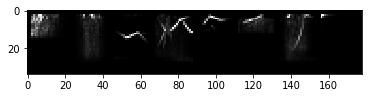

reconstructed


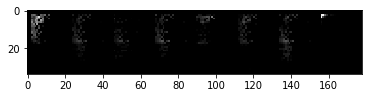

tensor([1, 1, 1, 1, 1, 1, 1, 0])


In [194]:
#extracting features and putting them into the csv folder for plotting
compression_dim=64

spec_dimension=FREQ_BINS*TIME_STEPS

# p="models/encode/nosynth_8_140_0.000462.pt"
# model_path="nosynth_8_150"
# s=torch.load(p)
# m = AE(input_shape=spec_dimension,compression_dim=compression_dim).to(device)
# m.load_state_dict(s)
# m.to(device)
dataiter=iter(spec_test_loader)
#does it work?
xy=dataiter.next()
def imshow(img):
    img = img      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images=xy["feats"].detach()[0:8].reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
y=xy["label"].detach()[0:8]
imshow(tv.utils.make_grid(images))

print("reconstructed")
image_batch=images.contiguous().view(-1, spec_dimension).to(device)
recon=m(image_batch).reshape([-1,1,FREQ_BINS,TIME_STEPS]).detach().cpu()
imshow(tv.utils.make_grid(recon))

print(y)

In [176]:
tv.utils.make_grid(images).shape

torch.Size([8, 30, 20])

In [91]:

encodings=np.empty([1,compression_dim+1])
d={"feats":[],"label":[],"path":[],"drum_type":[]}
for xy in spec_data_test:
#     print(xy)
    x=xy["feats"]
    y=xy["label"]
    p=xy["path"]
    drt=xy["drum_type"]

    m(x.contiguous().view(-1, spec_dimension).to(device))
    o=m.encoding.detach().cpu().numpy()
    d["feats"].append(list(o[0]))
    d["label"].append(y.item())
    d["path"].append(p)
    d["drum_type"].append(drt)

df=pd.DataFrame.from_dict(d)

df.to_csv("csvs/"+model_path+".csv",index=False)


In [1]:
# interactive plot to check DVN results
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from plotly.subplots import make_subplots
import pandas as pd
import time
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
import plotly_express as px
import plotly.graph_objs as go
import ipywidgets as widgets
import os
from sklearn import preprocessing
from ast import literal_eval
import io
from PIL import Image

min_max_scaler = preprocessing.MinMaxScaler()
n_neighbors = 10

class interactive_graph():
    def __init__(self,df,grouping_by="label",title=""):
        p = px.scatter(df, x="v1",y="v2",color=grouping_by,hover_data=["path"],color_discrete_sequence=px.colors.qualitative.Dark24)
    
        for trace in p.data:
            trace.update(hoverinfo="none",hovertemplate= '')
        
        self.hover_data = widgets.Textarea()  
        #audio and img widgets
        self.aud=widgets.Audio(autoplay=True,loop=False,embedding=True)
        self.audioImg=widgets.Image(
            value=b'',
            format='png',
            width='30%', 
        )
        #####
        layout = go.Layout(hovermode=False,)
        self.fig  = go.FigureWidget(p)
        self.fig.update_layout(
            title={
                'text': title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})
        for f in self.fig.data:
            f.on_hover(self.hover_fn)
    
    
    def hover_fn(self,trace, points, state):
        if points.point_inds:
            ind = points.point_inds[0]
            drmName=trace.customdata[ind][0][2:]
            filename=os.getcwd()+"/"+drmName
            with open(filename,'rb') as f:
                audio_data = f.read()
            self.aud.value=audio_data
            self.hover_data.value = str(drmName)+"\n"
            self.audioImg.value=self.audDisplay(filename)
            
    def audDisplay(self,f):
        #this got annoying because widget only accepts byte version of images
        audio_array=librosa.load(f)
        signals=audio_array[0]
        nz=np.max((SR-signals.shape[0],0))
        signals=np.concatenate([signals[0:SR],np.zeros(nz)]).astype("float32")

        sound={"signal":torch.tensor(signals),"label":'',"path":'',"drum_type":''}
        trns=specTrans(FREQ_BINS,time_steps=TIME_STEPS)
        ft=trns(sound)["feats"]
        sf=ft.detach().numpy()[0]
        #flip upside down
        sf=sf[-1:0:-1][:]
        plt.tight_layout()
        x=plt.imshow(sf)
        #convert to bytes so can be set to widget data
        buf = io.BytesIO()
        x.figure.savefig(buf, format='png')
        buf.seek(0)
        bufD=buf.getvalue()
        buf.close()    
        return bufD
def plotly_able_df(df):
    
    df["feats"]=df["feats"].apply(literal_eval)
    X=df["feats"]
    #convert series of arrays into a numpy array
    X=pd.DataFrame(X.to_list()).to_numpy()
    X = min_max_scaler.fit_transform(X)
    time_start = time.time()
#     tsne = TSNE(n_components=2, random_state=0, perplexity=100, verbose=1)
    tsne = Isomap(n_neighbors, n_components=2)
    # tsne = LocallyLinearEmbedding(n_neighbors,n_components=4)
    # tsne = SpectralEmbedding(n_neighbors=10,n_components=5,random_state=1)
    X_2d = tsne.fit_transform(X)
    df2=pd.concat([df["path"],df["label"],df["drum_type"],pd.Series(X_2d[:,0]),pd.Series(X_2d[:,1])],axis=1)
    df2.columns=["path","label","drum_type","v1","v2"]
    df2.label = df2.label.astype('str')
    return df2

# df_64=plotly_able_df(pd.read_csv("/csvs/spec_encode_64_290_0.002042.pt.csv"))
df_8=plotly_able_df(pd.read_csv("./csvs/nosynth_8_150.csv"))


In [2]:
ig=interactive_graph(df_8,grouping_by="drum_type",title="8 dim embedding")

display(ig.fig,widgets.HBox([ig.hover_data,ig.aud,ig.audioImg]))

FigureWidget({
    'data': [{'customdata': array([['./dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav'],
  …

In [530]:
ig=interactive_graph(df_8,grouping_by="drum_type",title="8 dim embedding")
display(ig.fig,widgets.HBox([ig.hover_data,ig.aud]))

FigureWidget({
    'data': [{'customdata': array([['./dk_data/tom_high/Roland Tr-909-TR-909Tom Hi 01.wav'],
  …